# Import relevant libraries

In [1]:
import os
import math
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

# Setup path

In [3]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [4]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [5]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [ ]:
# fee_age = perf_eval_df[['age', 'fee_cleaned']]
# fee_age

In [ ]:
# # the variance is quite high
# sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.mean, ci = 95)

In [ ]:
# # heavy-tailed distribution --> median would be a more sensible mid-point measure
# # as mean would be influenced by the outliers
# sns.histplot(fee_age['fee_cleaned'], kde = True)

In [ ]:
# # descriptive statistics
# desc_stat = fee_age.groupby('age')['fee_cleaned']\
#                    .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# # remove group with small number of observations
# desc_stat = desc_stat[desc_stat['count'] > 100]

In [ ]:
# # There are some outliers that greatly influence the mean and thus using median is more robust
# desc_stat

In [ ]:
# # visualize
# fig, ax = plt.subplots(figsize = (8, 6))

# sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, ci = None, alpha = 0.5)

# xlim = (desc_stat.index[0], desc_stat.index[-1])
# ylim = (min(desc_stat['median']*0.5), max(desc_stat['median'])*1.1)

# # fit polynomial to smoothen the trend (for adjustment coefficient)
# x = list(desc_stat['median'].index)
# y = list(desc_stat['median'])

# # smoothen the liner
# fit = np.polyfit(x, y, deg = 2)
# poly1d = np.poly1d(fit)

# # add adjustment line
# plt.plot(x, poly1d(x), '-', c = 'red')

# # get the turning point (slope < 0)
# idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0]

# # add vertical line at the turning point
# plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
#            colors = 'red', linestyles = 'dashed')

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

# plt.show()

In [ ]:
# # develop adjustment coefficient
# fitted_value = poly1d(x)

# baseline = fitted_value[0]
# base_value = np.divide(fitted_value, baseline)
# coef = np.reciprocal(base_value)

# temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
#                                'coef': coef})
# temp_df

In [ ]:
# # extend age range to cover the data using lower-upper bound coefficient
# age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
# adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
# adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
# adj_coef_table

## Homophily Analysis

In [6]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


### Create structured data

In [7]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_name'].unique())

In [8]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [9]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' 
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug (The case when club has no member yet)
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

### Analysis

In [10]:
# subset only `transfer_movement` == 'in'; we want to analyze the number of ties a player has
# before entering a team
df = node_edge_df[node_edge_df['transfer_movement'] == 'in']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [11]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 78625


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992,1,1
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992,1,1
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992,1,1
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992,1,2
4,Dordrecht'90,Michel Langerak,23.0,Attacking Midfield,VVV-Venlo,?,in,NaN,1992,1,3


In [12]:
# # only select the players that have at least two transfers to see the improvement
# target_player = list(df[df['num_transfer'] > 1]['player_name'])

# df = df[df['player_name'].isin(target_player)]
# df.reset_index(drop = True, inplace = True)
# print(f'number of observation: {len(df)}')
# df.head()

In [13]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

Number of players: 28976
Number of clubs: 401


In [14]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_name = temp_df.iloc[row]['club_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            # just in case some years are missing
            if year not in nested_dict.keys():
            
                pass
            
            else:
                
                aff_players = nested_dict[year][club_name]

                # add data to `year_member`
                year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():
            
                aff_clubs[club_name].update(year_member)
            
        else:
            
            aff_clubs[club_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [15]:
# was_in

In [16]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 78625


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2


In [17]:
# generate `k` column

# initiate a list
k = []
k_names = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        k_names.append([])
        
    else:  
        
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i-1]
        club = df['club_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            
            # just in case some years are missing
            if year not in nested_dict.keys():
                
                pass
            
            else:
                
                aff_player = was_in[player][prev_club][year]
                aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_names`, `k_val`
        k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
        k_val = len(k_name)
        
        # append data
        k_names.append(k_name)
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k
# add `k_name` column
df['k_name'] = k_names

In [18]:
# get k-pk table
k_count = df[['k']].dropna()
k_count['count'] = 1
k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
k_count.reset_index(inplace = True)
k_count['pk'] = k_count['count'] / sum(k_count['count'])

k_pk = k_count
# hardcode: further `k` does not seem relevant anymore
# xmax = 6
# k_pk = k_pk[k_pk['k'] <= xmax]
k_pk

,k,count,pk
0,0.0,19685,0.396483
1,1.0,7430,0.149651
2,2.0,3280,0.066064
3,3.0,1505,0.030313
4,4.0,751,0.015126
...,...,...,...
84,88.0,5,0.000101
85,89.0,3,0.000060
86,94.0,2,0.000040
87,96.0,5,0.000101


<BarContainer object of 89 artists>

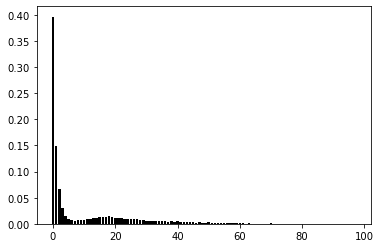

In [19]:
plt.bar(k_pk['k'],
         k_pk['pk'],
         color = 'black')

### Test the existence of homophily

#### Null case simulation
In this section, we simulated 10 random networks for the football data. Here are some important features:
1) The simulated data follow the same proportion of the number of transfers by players in the network  
2) The simulated data assume players only transfer within the 8 major leagues and are always in a club until 2020 (No retire or without club)

In [ ]:
# load data
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [ ]:
#select only necessary columns
data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]

In [ ]:
data_simul

In [ ]:
len(data_simul)

In [ ]:
# set-up

player_name_list = data_simul['player_name'].unique()
club_name_list = data_simul['club_name'].unique()
year_list = data_simul['year'].unique()

# in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
in_num = sum(data_simul['transfer_movement'] == 'in')

# number of movement distribution
num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
num_move['count'] = 1
num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
num_move = pd.DataFrame(num_move).reset_index()
num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
num_move = num_move / np.sum(num_move)
num_move = round(num_move * in_num)
num_move = pd.DataFrame(num_move).reset_index()

In [ ]:
num_move

In [ ]:
# get column names
col_names = data_simul.columns

# simulate data
rows = []
for t, count in zip(num_move['transfer_movement'], num_move['count']):
    for i in tqdm(range(int(count))):
        # get each column value
        player_name = np.repeat(np.random.choice(player_name_list, 1), t)
        club_name = np.random.choice(club_name_list, t, replace = False)
        transfer_movement = np.repeat('in', t)
        year = np.random.choice(year_list, t, replace = False)
        # format data
        row = list(zip(player_name, club_name, transfer_movement, year))
        # add to the list
        rows.extend(row)

# create dataframe
null_case = pd.DataFrame(data = rows, columns = col_names)
print(f'number of observation: {len(null_case)}')
null_case.head()

In [ ]:
# sort data
null_case = null_case.sort_values(by = ['player_name', 'year'])

# add column `num_transfer` which represent the number of time a player moved
null_case['count'] = 1
null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
null_case.drop(columns = 'count', inplace = True)
null_case.reset_index(drop = True, inplace = True)
print(f'number of observation: {len(null_case)}')
null_case

In [ ]:
# add `transfer_movement` == 'out'
to_add = []
for i in tqdm(range(len(null_case))):
    if (null_case.iloc[i]['num_transfer'] > 1) & \
    (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
        # create the 'out' case
        row = list(null_case.iloc[i].replace('in', 'out'))
        # add to `to_add` list
        to_add.append(row)
        
# add data to dataframe
extend = pd.DataFrame(data = to_add, columns = null_case.columns)
null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)
null_case

#### Null case analysis

In [ ]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(null_case['year'].unique()))
club_list = sorted(null_case['club_name'].unique())

In [ ]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = null_case[null_case['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' 
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

In [ ]:
df = null_case[null_case['transfer_movement'] == 'in']

In [ ]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
print(f'number of observation: {len(df)}')
df

In [ ]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

In [ ]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_name = temp_df.iloc[row]['club_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            # just in case some years are missing
            if year not in nested_dict.keys():
            
                pass
            
            else:
                
                aff_players = nested_dict[year][club_name]

                # add data to `year_member`
                year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():
            
                aff_clubs[club_name].update(year_member)
            
        else:
            
            aff_clubs[club_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [ ]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df

In [ ]:
# generate `k` column

# initiate a list
k = []
k_names = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        k_names.append([])
        
    else:  
        
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i-1]
        club = df['club_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            
            # just in case some years are missing
            if year not in nested_dict.keys():
                
                pass
            
            else:
                
                aff_player = was_in[player][prev_club][year]
                aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_names`, `k_val`
        k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
        k_val = len(k_name)
        
        # append data
        k_names.append(k_name)
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k
# add `k_name` column
df['k_name'] = k_names

In [ ]:
# get k-pk table
k_count = df[['k']].dropna()
k_count['count'] = 1
k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
k_count.reset_index(inplace = True)
k_count['pk'] = k_count['count'] / sum(k_count['count'])

k_pk = k_count
# hardcode: further `k` does not seem relevant anymore
# xmax = 6
# k_pk = k_pk[k_pk['k'] <= xmax]
k_pk

In [ ]:
plt.bar(k_pk['k'],
         k_pk['pk'],
         color = 'black')

#### Iteration

In [ ]:
# set seed
np.random.seed(777)

# simulate data 10 times
t = 10

for n in tqdm(range(t)):
    # load data
    node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
    
    #select only necessary columns
    data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]
    
    # set-up
    player_name_list = data_simul['player_name'].unique()
    club_name_list = data_simul['club_name'].unique()
    year_list = data_simul['year'].unique()

    # in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
    in_num = sum(data_simul['transfer_movement'] == 'in')

    # number of movement distribution
    num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
    num_move['count'] = 1
    num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
    num_move = pd.DataFrame(num_move).reset_index()
    num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
    num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
    num_move = num_move / np.sum(num_move)
    num_move = round(num_move * in_num)
    num_move = pd.DataFrame(num_move).reset_index()
    
    # get column names
    col_names = data_simul.columns

    # simulate data
    rows = []
    for t, count in zip(num_move['transfer_movement'], num_move['count']):
        for i in tqdm(range(int(count))):
            # get each column value
            player_name = np.repeat(np.random.choice(player_name_list, 1), t)
            club_name = np.random.choice(club_name_list, t, replace = False)
            transfer_movement = np.repeat('in', t)
            year = np.random.choice(year_list, t, replace = False)
            # format data
            row = list(zip(player_name, club_name, transfer_movement, year))
            # add to the list
            rows.extend(row)

    # create dataframe
    null_case = pd.DataFrame(data = rows, columns = col_names)
    
    # sort data
    null_case = null_case.sort_values(by = ['player_name', 'year'])

    # add column `num_transfer` which represent the number of time a player moved
    null_case['count'] = 1
    null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
    null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
    null_case.drop(columns = 'count', inplace = True)
    null_case.reset_index(drop = True, inplace = True)
    
    # add `transfer_movement` == 'out'
    to_add = []
    for i in tqdm(range(len(null_case))):
        if (null_case.iloc[i]['num_transfer'] > 1) & \
        (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
            # create the 'out' case
            row = list(null_case.iloc[i].replace('in', 'out'))
            # add to `to_add` list
            to_add.append(row)

    # add data to dataframe
    extend = pd.DataFrame(data = to_add, columns = null_case.columns)
    null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
    null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
    null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)
    
    # 2 components needed: 'year_list', 'club_list'
    year_list = sorted(sorted(null_case['year'].unique()))
    club_list = sorted(null_case['club_name'].unique())
    
    # nested dictionary: year: `club_member`
    nested_dict = {}
    prev_year = None

    # loop over year:
    for year in tqdm(year_list):

        if prev_year in nested_dict.keys():

            # retrieve club-player info in the previous year for the second year and so on
            club_member = copy.deepcopy(nested_dict[prev_year])

        else:
            # initiate a dictionary of clubs (keys) and their affiliated players (values)
            club_member = {}

        # subset data by year
        data = null_case[null_case['year'] == year]

        # subset for transfer_movement == 'in', 'out' 
        data_in = data[data['transfer_movement'] == 'in']
        data_out = data[data['transfer_movement'] == 'out']

        # loop over club:
        for club in club_list:

            # subset data by club 
            temp_data_in = data_in[data_in['club_name'] == club]
            temp_data_out = data_out[data_out['club_name'] == club]

            # update all players in that club in the dictionary (`club_member`)
            player_list_in = list(temp_data_in['player_name'])
            player_list_out = list(temp_data_out['player_name'])

            if prev_year in nested_dict.keys():

                # catch bug
                if club_member[club] is None:
                    club_member[club] = []

                # adjust for members who move in
                club_member[club].extend(player_list_in)
                # adjust for members who move out
                remove_elem_by_list(club_member[club], player_list_out)

            else:
                # update club_member info
                club_member[club] = remove_elem_by_list(player_list_in, player_list_out)

        # store `club_member` in `nested_dict`
        nested_dict[year] = club_member

        # set previous year
        prev_year = year
        
    # set-up
    df = null_case[null_case['transfer_movement'] == 'in']
        
    # add column `num_transfer` which represent the number of time a player moved
    df['count'] = 1
    df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
    df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
    df.drop(columns = 'count', inplace = True)
    
    # get player_list
    player_list = list(df['player_name'].unique())
    
    # initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
    was_in = {}

    # loop over the dataset
    for player in tqdm(player_list):

        # subset df by player
        temp_df = df[df['player_name'] == player]

        # reset_index
        temp_df.reset_index(drop = True, inplace = True)

        # initiate inside dictionaries
        aff_clubs = {}

        """
        loop over the dataset to get the year and club name 
        this represent that a player stay in a club from year A - year B 
        in this case, we can ignore the last row because no further analysis is needed
        as the next transaction has not occurred yet
        """

        for row in range(len(temp_df) - 1):

            # initiate inside dictionaries
            year_member = {}

            club_name = temp_df.iloc[row]['club_name']

            year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])

            # get the affiliated player each year from `nested_dict`
            for year in year_list:

                aff_players = nested_dict[year][club_name]

                # add data to `year_member`
                year_member[year] = aff_players

            # add data to aff_club 

            # adjust for the case when player moves back to the club he's been before
            if club_name in aff_clubs.keys():

                    aff_clubs[club_name].update(year_member)

            else:

                aff_clubs[club_name] = year_member

        # add data to was_in
        was_in[player] = aff_clubs
        
    # table we will use
    df.sort_values(['player_name', 'num_transfer'], inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    # generate `k` column

    # initiate a list
    k = []
    k_names = []

    # loop over the dataset
    for i in tqdm(range(len(df))):

        # there is nothing to do with the `k` for the first transfer
        if df['num_transfer'][i] == 1:  

            k.append(None)
            k_names.append([])

        else:  

            # get necessary variables (keys)
            player = df['player_name'][i]
            prev_club = df['club_name'][i-1]
            club = df['club_name'][i]
            prev_year = df['year'][i-1]
            this_year = df['year'][i]
            year_range = np.arange(prev_year, this_year)

            # get all the affiliated players
            aff_players = []
            for year in year_range:

                # just in case some years are missing
                if year not in nested_dict.keys():

                    pass

                else:

                    aff_player = was_in[player][prev_club][year]
                    aff_players.extend(aff_player)

            # get all member in the club player is joining
            in_club_player = nested_dict[this_year][club]

            if df['num_transfer'][i] > 2:
                # accumulate affiliated players
                aff_players = set.union(set(prev_set), set(aff_players))

            # get `k_names`, `k_val`
            k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
            k_val = len(k_name)

            # append data
            k_names.append(k_name)
            k.append(k_val)

            # previous affiliated player set
            prev_set = set(aff_players)

    # add `k` column
    df['k'] = k
    # add `k_name` column
    df['k_name'] = k_names
    
    # get k-pk table
    k_count = df[['k']].dropna()
    k_count['count'] = 1
    k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
    k_count.reset_index(inplace = True)
    k_count['pk'] = k_count['count'] / sum(k_count['count'])
    k_count = k_count.drop(columns = 'count')
    
    if n == 0:
        k_pk = k_count
    else:
        k_pk = pd.concat((k_pk, k_count))

    # save file
    out_path = os.path.join('output', 'k_pk.csv') 
    k_pk.to_csv(out_path)
    
    # print confirming result
    print(f'\
    Number of iteration: {n+1}\n\
    len(k_pk): {len(k_pk)}')

#### Hypothesis Testing

In [20]:
file_path = os.path.join('output', 'k_pk.csv') 
null_k_pk = pd.read_csv(file_path)

In [21]:
null_k_pk = pd.DataFrame(null_k_pk.groupby('k')['pk'].agg(['mean', 'std']))

In [22]:
null_k_pk

,mean,std
k,,
0.0,0.848789,0.001628
1.0,0.120899,0.001231
2.0,0.021189,0.000735
3.0,0.003736,0.000216
4.0,0.000706,0.000146
...,...,...
152.0,0.000017,NaN
153.0,0.000017,NaN
154.0,0.000017,NaN


In [23]:
null_k_pk.reset_index(inplace = True)

In [24]:
k_pk_table = pd.merge(k_pk, null_k_pk, on = 'k', how = 'left')
k_pk_table

,k,count,pk,mean,std
0,0.0,19685,0.396483,0.848789,0.001628
1,1.0,7430,0.149651,0.120899,0.001231
2,2.0,3280,0.066064,0.021189,0.000735
3,3.0,1505,0.030313,0.003736,0.000216
4,4.0,751,0.015126,0.000706,0.000146
...,...,...,...,...,...
84,88.0,5,0.000101,0.000030,0.000016
85,89.0,3,0.000060,0.000041,0.000009
86,94.0,2,0.000040,0.000045,0.000026
87,96.0,5,0.000101,0.000037,0.000014


In [34]:
k_pk_table['z'] = (k_pk_table['pk'] - k_pk_table['mean']) / k_pk_table['std']
k_pk_table.head(6)

,k,count,pk,mean,std,z
0,0.0,19685,0.396483,0.848789,0.001628,-277.826142
1,1.0,7430,0.149651,0.120899,0.001231,23.348454
2,2.0,3280,0.066064,0.021189,0.000735,61.021911
3,3.0,1505,0.030313,0.003736,0.000216,122.999083
4,4.0,751,0.015126,0.000706,0.000146,98.893939
5,5.0,462,0.009305,0.000125,0.000051,178.456067


#### Visualization

In [ ]:
fig = plt.figure(figsize = (4, 4))

ax = fig.add_subplot(1, 1, 1)

ax.bar(x = k_count['k'],
        height = k_count['count'])

ax.set_xlabel('k', size = 14)
ax.set_ylabel('count', size = 14)
ax.set_title('k - count (Homophily)', size = 16)

In [ ]:
k_count

## Top player similarity analysis

In [ ]:
rating_df = pd.read_csv(os.path.join(cleaned_data_path, 'player_rating.csv'))

In [ ]:
rating_eval_df = pd.merge(perf_eval_df, rating_df, on = ['player_name', 'year'], how = 'inner')

In [ ]:
rating_eval_df = pd.DataFrame(rating_eval_df.groupby(['player_name', 'age', 'position'])['overall_rating'].agg('mean'))
rating_eval_df.reset_index(inplace = True)
top_player_list = rating_eval_df[rating_eval_df['overall_rating'] > 85]['player_name'].unique()
top_player_list

In [ ]:
top_eval = df[df['player_name'].isin(top_player_list)]

In [ ]:
top_eval[top_eval['num_transfer'] >= 3][['club_name', 'player_name', 'age', 'year', 'club_involved_name', 'adjusted_fee','k', 'perf_change_adjusted']].sort_values(by = 'year')

In [ ]:
pd.DataFrame(top_eval.groupby('club_name')['transfer_movement'].agg('count'))\
.sort_values(by = 'transfer_movement', ascending = False)

In [ ]:
player_in_madrid = top_eval[top_eval['club_name'] == 'Real Madrid']['player_name'].unique()

In [ ]:
top_eval[top_eval['player_name'].isin(player_in_madrid)]

## Homophily-Performance Analysis

In [ ]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

### Create structured data

In [ ]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_name'].unique())

In [ ]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [ ]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' 
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug (The case when club has no member yet)
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

### Performance Analysis (Fee)

In [ ]:
perf_eval_df.head()

In [ ]:
adj_coef_table.head()

In [ ]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on = 'age', how = 'left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'], perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns = 'coef', inplace = True)
perf_eval_df.head()

In [ ]:
# subset only `transfer_movement` == 'in'; we want to analyze the number of ties a player has
# before entering a team
df = perf_eval_df[perf_eval_df['transfer_movement'] == 'in']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [ ]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
print(f'number of observation: {len(df)}')
df.head()

In [ ]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
print(f'number of observation: {len(df)}')
df.head()

In [ ]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

In [ ]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_name = temp_df.iloc[row]['club_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():
            
                aff_clubs[club_name].update(year_member)
            
        else:
            
            aff_clubs[club_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [ ]:
# was_in

In [ ]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
print(f'number of observation: {len(df)}')
df.head()

In [ ]:
# get number of years in the club
num_year_stay = []
for i in range(len(df)):
    if df['num_transfer'][i] < df['max_transfer'][i]:
        val = df['year'][i+1] - df['year'][i]
        num_year_stay.append(val)
    else:
        val = max(df['year']) - df['year'][i]
        num_year_stay.append(val)
df['num_year_stay'] = num_year_stay
df.head()

In [ ]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i-1]
        club = df['club_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [ ]:
# change in fee as a proxy of performance --> `perf_change`
df['perf_change'] = df.groupby('player_name')['fee_cleaned'].pct_change()

In [ ]:
# change in adjusted fee as a proxy of performance --> `perf_change_adjusted`
df['perf_change_adjusted'] = df.groupby('player_name')['adjusted_fee'].pct_change()

In [ ]:
df.head()

In [ ]:
# average number of year stayed by k
for_num_year = df[['num_year_stay', 'k']].dropna()

In [ ]:
num_year_df = pd.DataFrame(for_num_year.groupby('k')['num_year_stay'].agg(['mean', 'count'])).reset_index()
num_year_df.head()

In [ ]:
# get `k-perf` table
k_perf = df[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf.head()

In [ ]:
k_perf.sort_values(by = 'k', ascending = False).head()

In [ ]:
pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['median', 'count'])).reset_index()

In [ ]:
pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted'].agg(['median', 'count'])).reset_index()

#### Visualization

In [ ]:
# get average perf_change by k
table = pd.DataFrame(k_perf.groupby('k')['perf_change']\
                     .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [ ]:
table['pk'] = table['count'] / sum(table['count'])

In [ ]:
# get average perf_change_adjusted by k
table2 = pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted']\
                      .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [ ]:
table2['pk'] = table['count'] / sum(table['count'])

In [ ]:
# get the index where `count` >= 30
xmax = max(table[table['count'] >= 30].index)

table = table[:xmax+1]
table2 = table2[:xmax+1]

In [ ]:
# set-up
table.rename(columns = {'median': 'med_perf_change'}, inplace = True)
table

In [ ]:
# set-up
table2.rename(columns = {'median': 'med_perf_change'}, inplace = True)
table2

In [ ]:
# set-up
num_year_df = num_year_df[:xmax+1]
num_year_df.rename(columns = {'mean': 'average_year_stayed'}, inplace = True)
num_year_df

In [ ]:
fig = plt.figure(figsize = (14, 14))

ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

"""Performance-Homophily without age adjustment"""
ax0.plot(table['k'],
         table['med_perf_change'],
         color = 'black')

ax0.set_xlabel('Homophily', size = 14)
ax0.set_ylabel('Change in Performance', size = 14)
ax0.set_title('Performance - Homophily', size = 16)

# get x limit
ylim = ax0.get_ylim()

# ax0.set_xlim((0,xmax))
# ax0.set_ylim((-1,1))


"""Performance-Homophily with age adjustment"""
ax1.plot(table['k'],
         table2['med_perf_change'],
         color = 'black')

ax1.set_xlabel('Homophily', size = 14)
ax1.set_ylabel('Change in Performance', size = 14)
ax1.set_title('Performance - Homophily (adjusted)', size = 16)

# ax1.set_xlim((0,xmax))
ax1.set_ylim(ylim)

"""Tenure-Homophily"""
ax2.bar(x = num_year_df['k'],
        height = num_year_df['average_year_stayed'])

ax2.set_xlabel('Homophily', size = 14)
ax2.set_ylabel('Tenure', size = 14)
ax2.set_title('Tenure - Homophily', size = 16)

# ax2.set_xlim((-1,xmax))

"""k-count (Homophily)"""
ax3.bar(x = table['k'],
        height = table['pk'])

ax3.set_xlabel('k', size = 14)
ax3.set_ylabel('pk', size = 14)
ax3.set_title('k - pk (Homophily)', size = 16)

plt.show()